In [2]:
import os
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature

from joblib import Parallel, delayed
from tqdm import tqdm


In [3]:
# Load the data (ds_all)
ds_all_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/test2'
ds_all = xr.open_dataset(os.path.join(ds_all_fp, 'ds_all.nc'))

ds_all['time'] = pd.to_datetime(ds_all['time'], origin='unix', unit='D')

### Resample the data
Get the average for each week of every year. 

The resample method groups data by a certain time interval ('W' for weekly in this case) and applies a function to each group. 

In [32]:
# uncomment last line to run
def run_resample_data():

    # Load the data (ds_all)
    ds_all_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/test2'
    ds_all = xr.open_dataset(os.path.join(ds_all_fp, 'ds_all.nc'))

    # Resample the data
    def weekly_average(ds):
        ds['time'] = pd.to_datetime(ds['time'], origin='unix', unit='D')
        
        # Resample to weekly data and compute the mean
        weekly_ds = ds.resample(time='W').mean()

        return weekly_ds

    weekly_ds_all = weekly_average(ds_all)

    # write weekly_ds_all to a netcdf file
    output_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
    if not os.path.exists(output_fp):
        os.makedirs(output_fp)

    weekly_ds_all.to_netcdf(os.path.join(output_fp, 'weekly_ds_all.nc'))

# run_resample_data()

### Load resampled weekly data

In [5]:
# Load the weekly dataset
ds_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
weekly_ds_all = xr.open_dataset(os.path.join(ds_fp, 'weekly_ds_all.nc'))

In [3]:
weekly_ds_all

<xarray.Dataset>
Dimensions:  (time: 1376, lat: 215, lon: 627)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-07 1997-09-14 ... 2024-01-14
  * lat      (lat) float64 72.28 72.27 72.26 72.24 ... 70.08 70.07 70.06 70.05
  * lon      (lon) float64 -56.86 -56.85 -56.84 -56.83 ... -50.36 -50.35 -50.34
Data variables:
    chlor_a  (time, lat, lon) float64 ...

In [33]:
print(weekly_ds_all['chlor_a'].isel(lat=100, lon=100))

<xarray.DataArray 'chlor_a' (time: 1376)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 1997-09-07 1997-09-14 ... 2024-01-14
    lat      float64 71.23
    lon      float64 -55.82


### time series (raw data; weekly) at 100,100

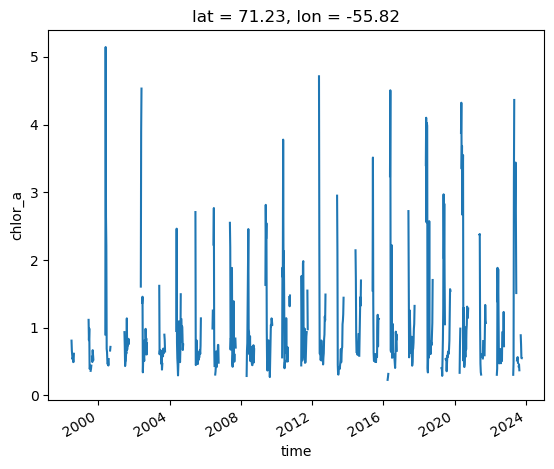

In [6]:
# plot the data at [100,100] as a timeseries line
fig, ax = plt.subplots()
weekly_ds_all['chlor_a'].isel(lat=100, lon=100).plot(ax=ax)
plt.show()
plt.close()

### Set winter values to 0. Interpolate remaining NaN data

In [7]:
# Select the point
point_data = weekly_ds_all['chlor_a'].isel(lat=100, lon=100)

# Create a mask where True corresponds to December, January, March, or April
# Set the values in December, January, March, or April to 0
mask = point_data['time.month'].isin([12, 1, 3, 4])
updated_data = point_data.where(~mask, 0)

# interpolate NaN values
interpolated_data = updated_data.interpolate_na(dim='time')

print(interpolated_data)

<xarray.DataArray 'chlor_a' (time: 1376)>
array([nan, nan, nan, ...,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 1997-09-07 1997-09-14 ... 2024-01-14
    lat      float64 71.23
    lon      float64 -55.82


### Cleaned interpolated data at a point

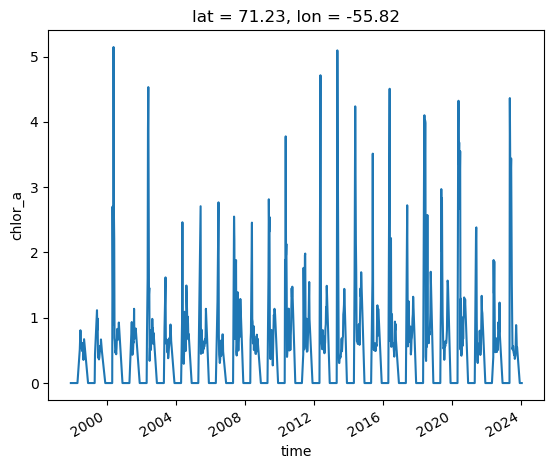

In [8]:
# plot the data at [100,100] as a timeseries line
fig, ax = plt.subplots()
interpolated_data.plot(ax=ax)
plt.show()
plt.close()

## Finding seasonality with Fourier 

### Baseline: What would random (nonseasonal) data look like?

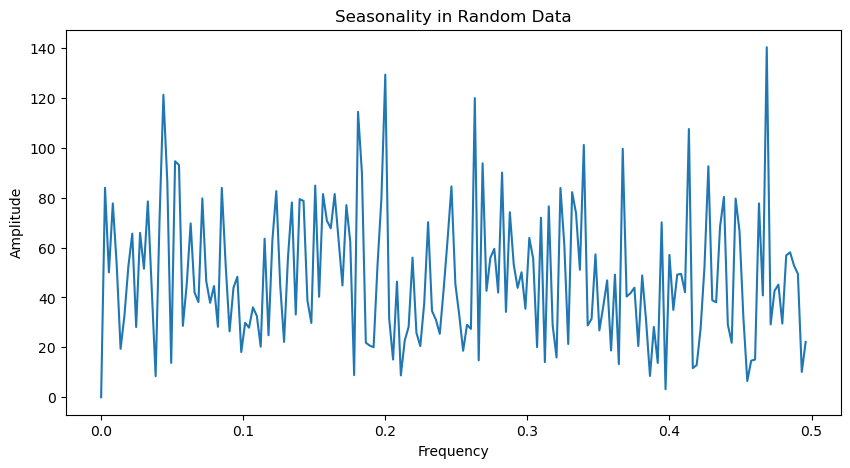

In [ ]:
# Generate random data
pixel_data = np.random.uniform(0, 10, 365)
pixel_data = pixel_data - pixel_data.mean()

# Apply Fourier Transform
fft_vals = np.fft.fft(pixel_data)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(pixel_data))

# Plot the absolute FFT values for positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('BASE CASE: Seasonality in Random Data')
plt.show()

### Fast Fourier with raw data at a point

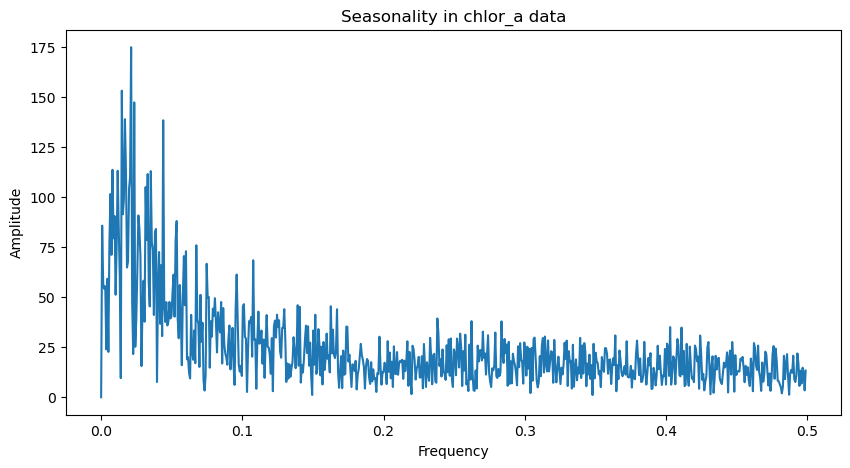

In [ ]:
# Select a pixel
pixel_data = ds_all['chlor_a'][:, 100, 100] - 0.98497576

# Remove NaN values
valid_mask = np.isfinite(pixel_data)
y = pixel_data[valid_mask]

# Apply Fourier Transform
fft_vals = np.fft.fft(y)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(y))

# Plot the absolute FFT values for positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Seasonality in chlor_a data')
plt.show()

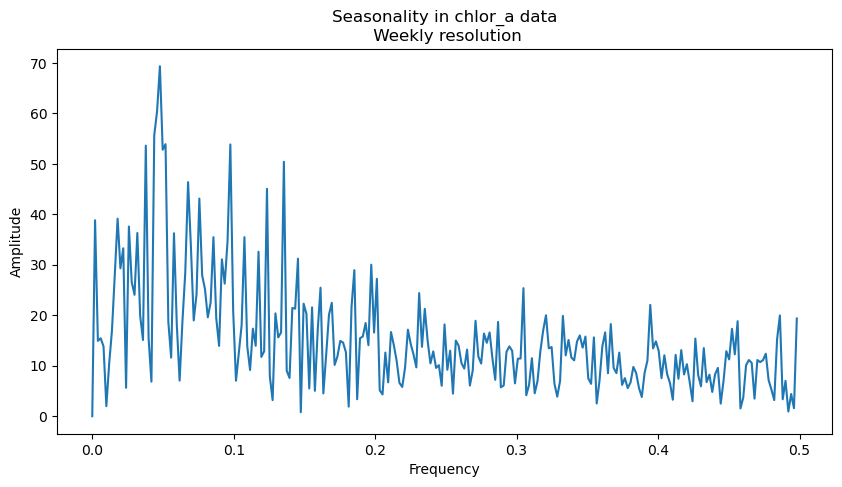

In [10]:
# Select a pixel
pixel_data = weekly_ds_all['chlor_a'][:, 100, 100]
pixel_data = pixel_data - pixel_data.mean()

# Remove NaN values
valid_mask = np.isfinite(pixel_data)
y = pixel_data[valid_mask]

# Apply Fourier Transform
fft_vals = np.fft.fft(y)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(y))

# Plot the absolute FFT values for positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Seasonality in chlor_a data\n Weekly resolution')
plt.show()

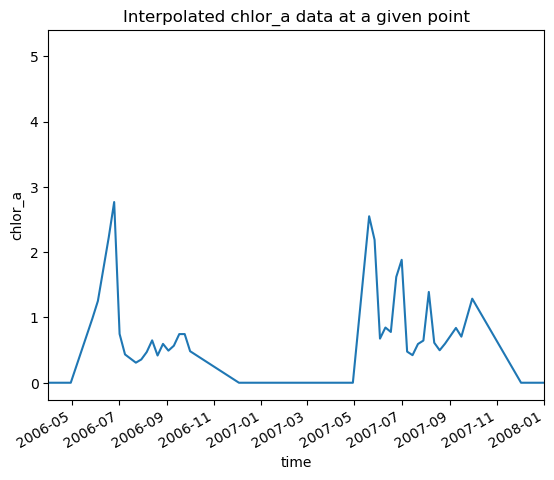

In [16]:
fig, ax = plt.subplots()
interpolated_data.plot(ax=ax)
plt.title('Interpolated chlor_a data at a given point')

# set x axis to half
ax.set_xlim([datetime(2006, 4, 1), datetime(2008, 1, 1)])

plt.show()
plt.close()

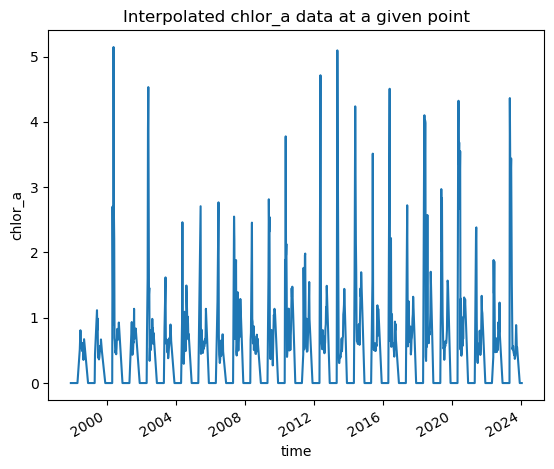

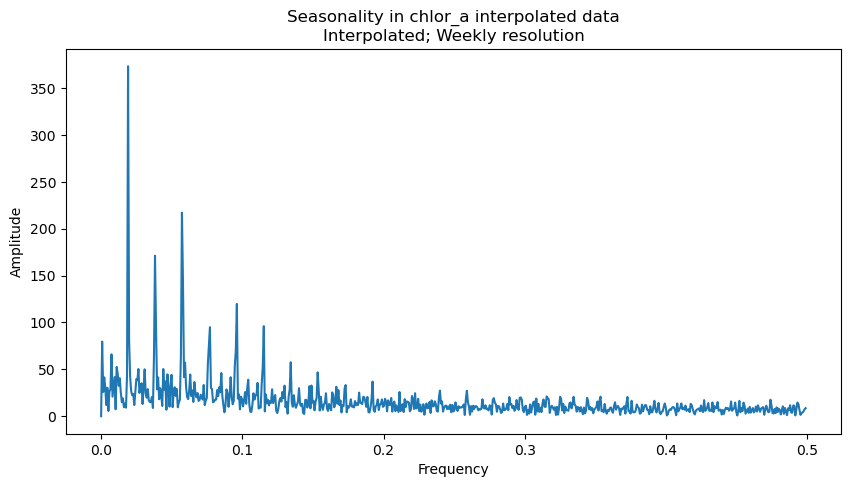

In [11]:
# plot the data at [100,100] as a timeseries line
fig, ax = plt.subplots()
interpolated_data.plot(ax=ax)
plt.title('Interpolated chlor_a data at a given point')
plt.show()
plt.close()

# Select a pixel
pixel_data = interpolated_data - interpolated_data.mean()

# Remove NaN values
valid_mask = np.isfinite(pixel_data)
y = pixel_data[valid_mask]

# Apply Fourier Transform
fft_vals = np.fft.fft(y)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(y))

# Plot the absolute FFT values for positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Seasonality in chlor_a interpolated data\nInterpolated; Weekly resolution')
plt.show()

In [17]:
# arg max of freqs
max_freq = freqs[np.argmax(fft_abs[:len(fft_abs)//2])]
print(1/max_freq)

# what is the 2nd and 3rd highest frequency
fft_abs_copy = fft_abs.copy()
fft_abs_copy[np.argmax(fft_abs)] = 0
max_freq2 = freqs[np.argmax(fft_abs_copy[:len(fft_abs)//2])]
print(1/max_freq2)


52.42307692307692
17.474358974358974
17.474358974358974


In [20]:
# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Use these indices to get the corresponding frequencies
dominant_freqs = freqs[sorted_indices]

print(1/dominant_freqs[0:10])

[  52.42307692   17.47435897   26.21153846   17.25316456   10.40458015
    8.68152866   12.98095238   25.71698113   50.48148148 1363.
   13.10576923   10.48461538  136.3          17.7012987    26.7254902
    7.44808743   16.82716049   13.23300971   10.56589147    8.73717949
   90.86666667   22.71666667   37.86111111   32.45238095    6.5215311
   11.75         85.1875       21.296875     15.84883721   20.04411765
   54.52         48.67857143   17.0375      104.84615385   10.904
  454.33333333   24.78181818   75.72222222   40.08823529    9.59859155
   38.94285714   21.98387097    5.20229008   15.14444444    9.02649007
   34.94871795    8.79354839   20.34328358   13.76767677    5.77542373
    6.71428571    7.70056497   80.17647059   35.86842105    6.78109453
    6.00440529  113.58333333   16.62195122   11.95614035   19.1971831
   33.24390244  227.16666667  340.75         12.85849057    9.66666667
    7.13612565   23.9122807    20.96923077    5.8          12.73831776
   18.67123288   30.28

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_29937/1527116359.py:7: RuntimeWarning: divide by zero encountered in true_divide
  print(1/dominant_freqs)


### daily interpolated FFT

In [23]:
ds_all

<xarray.Dataset>
Dimensions:  (time: 9600, lat: 215, lon: 627)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2024-01-11
  * lat      (lat) float64 72.28 72.27 72.26 72.24 ... 70.08 70.07 70.06 70.05
  * lon      (lon) float64 -56.86 -56.85 -56.84 -56.83 ... -50.36 -50.35 -50.34
Data variables:
    chlor_a  (time, lat, lon) float64 ...

In [24]:
# Select the point
point_data = ds_all['chlor_a'].isel(lat=100, lon=100)

# Create a mask where True corresponds to December, January, March, or April
# Set the values in December, January, March, or April to 0
mask = point_data['time.month'].isin([12, 1, 3, 4])
updated_data = point_data.where(~mask, 0)

# interpolate NaN values
interpolated_data_daily = updated_data.interpolate_na(dim='time')

print(interpolated_data_daily)

<xarray.DataArray 'chlor_a' (time: 9600)>
array([nan, nan, nan, ...,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2024-01-11
    lat      float64 71.23
    lon      float64 -55.82


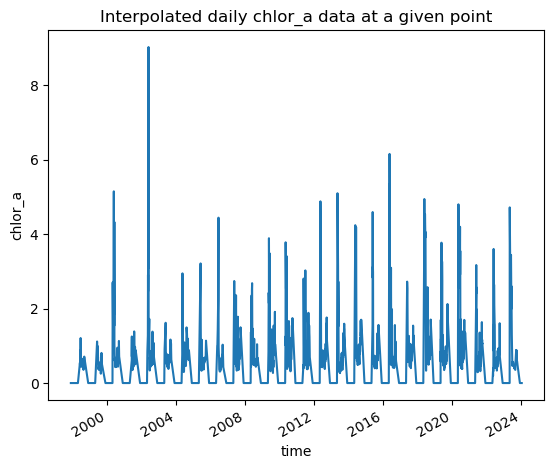

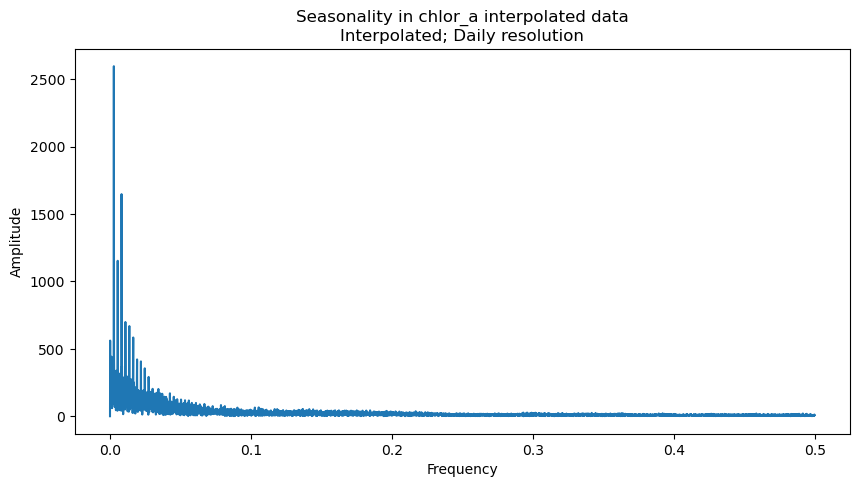

In [25]:
# plot the data at [100,100] as a timeseries line
fig, ax = plt.subplots()
interpolated_data_daily.plot(ax=ax)
plt.title('Interpolated daily chlor_a data at a given point')
plt.show()
plt.close()

# Select a pixel
pixel_data = interpolated_data_daily - interpolated_data_daily.mean()

# Remove NaN values
valid_mask = np.isfinite(pixel_data)
y = pixel_data[valid_mask]

# Apply Fourier Transform
fft_vals = np.fft.fft(y)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(y))

# Plot the absolute FFT values for positive frequencies
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Seasonality in chlor_a interpolated data\nInterpolated; Daily resolution')
plt.show()

In [30]:
# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Use these indices to get the corresponding frequencies
dominant_freqs = freqs[sorted_indices]
print(dominant_freqs[:5])
print(1/(dominant_freqs[:5]))

[0.00272937 0.00818812 0.00545874 0.00829309 0.01091749]
[366.38461538 122.12820513 183.19230769 120.58227848  91.59615385]


# Clean - Convolute - Detrend

In [46]:
# Load the data (ds_all)
ds_all_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/test2'
ds_all = xr.open_dataset(os.path.join(ds_all_fp, 'ds_all.nc'))

ds_all['time'] = pd.to_datetime(ds_all['time'], origin='unix', unit='D')

In [47]:
point = ds_all['chlor_a'].isel(lat=100, lon=100)

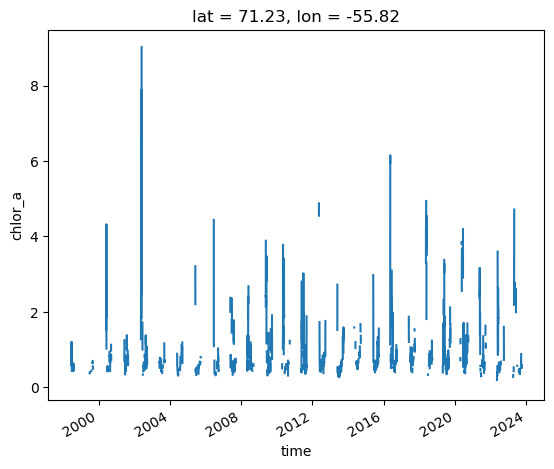

In [5]:
# plot point
fig, ax = plt.subplots()
point.plot(ax=ax)
plt.show()
plt.close()

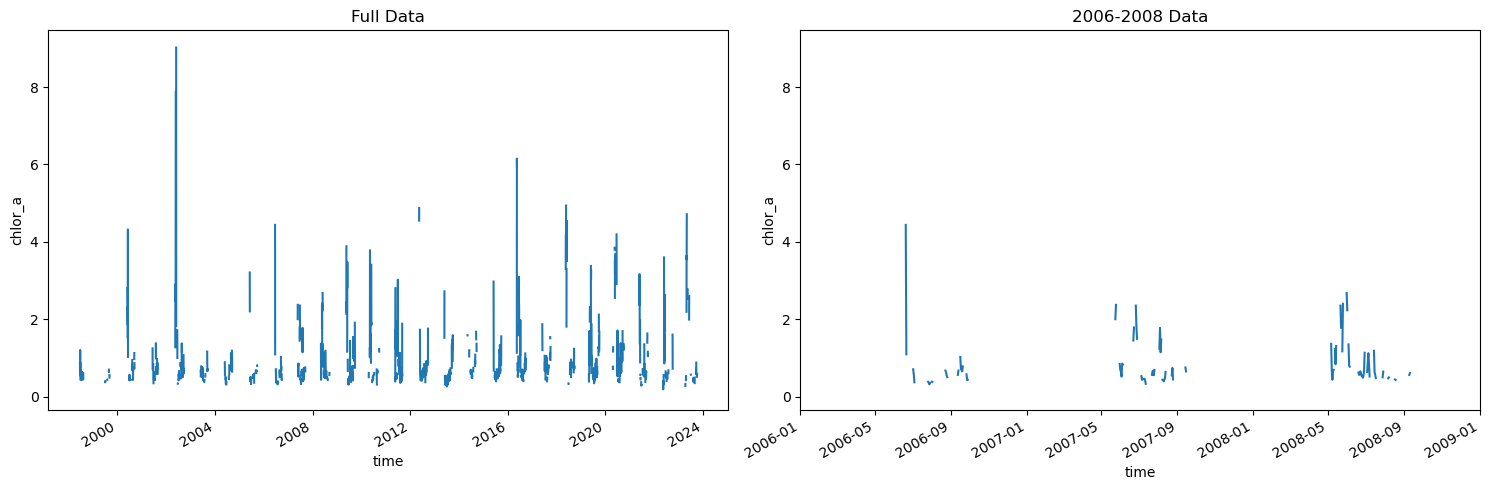

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the entire data on the first subplot
point.plot(ax=axs[0])
axs[0].set_title('Full Data')

# Plot the data for 2006-2008 on the second subplot
point.plot(ax=axs[1])
axs[1].set_xlim([datetime(2006, 1, 1), datetime(2009, 1, 1)])
axs[1].set_title('2006-2008 Data')

plt.tight_layout()
plt.show()

#### clean / interp

In [100]:
# mask = point['time.month'].isin([12, 1, 2]) 
mask = point['time.month'].isin([12, 1, 2]) | (point['time.month'].isin([11, 3, 4]) & point.isnull())
updated_data = point.where(~mask, 0)

interpolated_data_daily = updated_data.interpolate_na(dim='time')

print(interpolated_data_daily)

<xarray.DataArray 'chlor_a' (time: 9600)>
array([nan, nan, nan, ...,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2024-01-11
    lat      float64 71.23
    lon      float64 -55.82


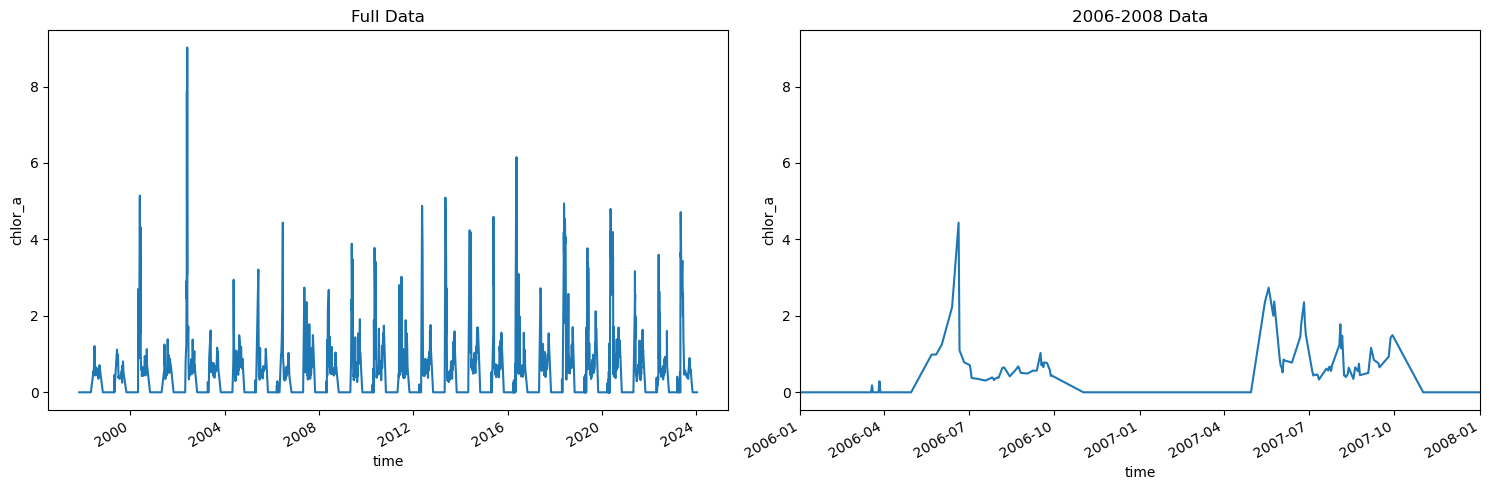

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the entire data on the first subplot
interpolated_data_daily.plot(ax=axs[0])
axs[0].set_title('Full Data')

# Plot the data for 2006-2008 on the second subplot
interpolated_data_daily.plot(ax=axs[1])
axs[1].set_xlim([datetime(2006, 1, 1), datetime(2008, 1, 1)])
axs[1].set_title('2006-2008 Data')

plt.tight_layout()
plt.show()

#### convolution 14-day rolling mean

In [102]:
# get a 7 day rolling mean
rolling_mean = interpolated_data_daily.rolling(time=14, center=True).mean()

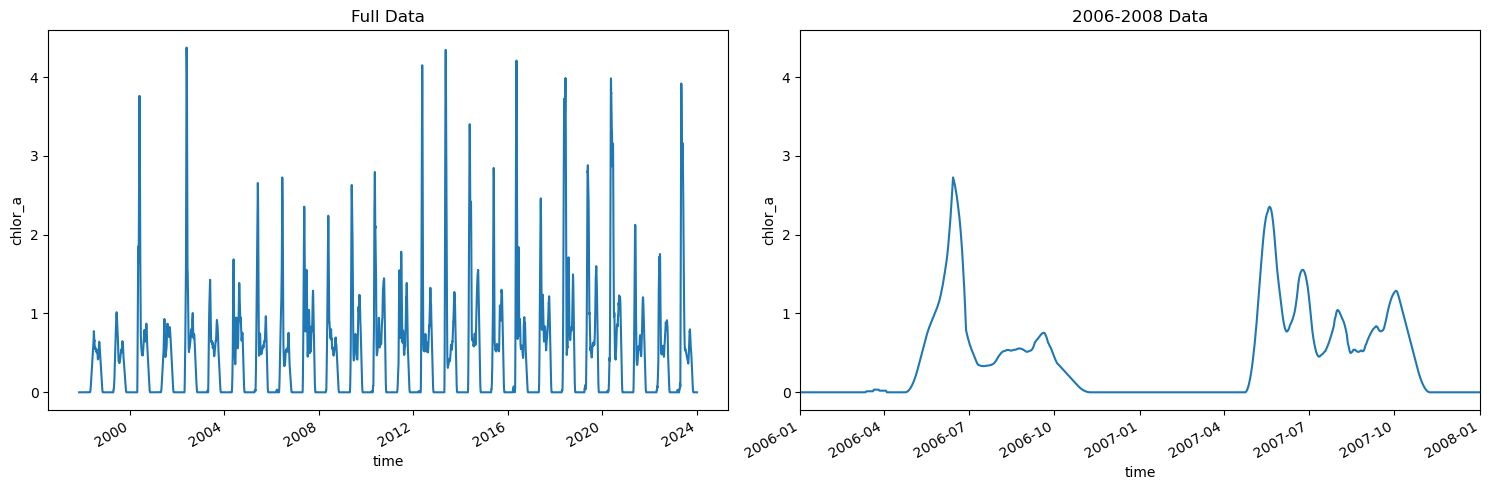

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the entire data on the first subplot
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Full Data')

# Plot the data for 2006-2008 on the second subplot
rolling_mean.plot(ax=axs[1])
axs[1].set_xlim([datetime(2006, 1, 1), datetime(2008, 1, 1)])
axs[1].set_title('2006-2008 Data')

plt.tight_layout()
plt.show()

##### FFT

In [104]:
# Select a pixel
pixel_data = rolling_mean - rolling_mean.mean()

# Remove NaN values
valid_mask = np.isfinite(pixel_data)
y = pixel_data[valid_mask]

# Apply Fourier Transform
fft_vals = np.fft.fft(y)

# Get absolute value of FFT values
fft_abs = np.abs(fft_vals)

# Create an array of frequencies
freqs = np.fft.fftfreq(len(y))

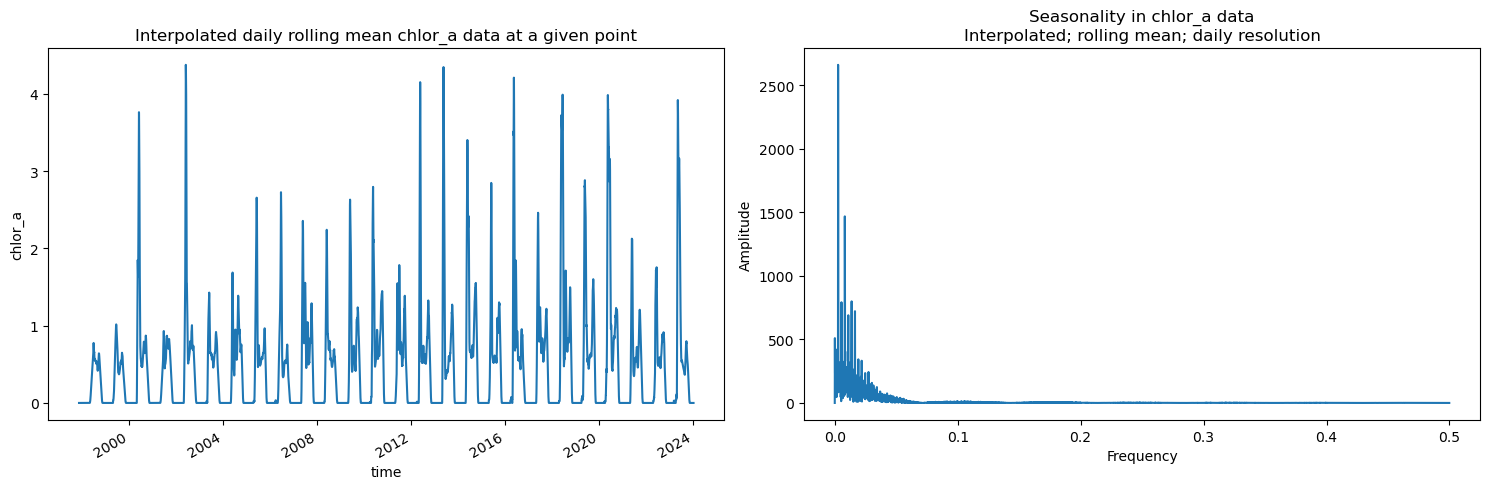

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the time series data on the first subplot
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Interpolated daily rolling mean chlor_a data at a given point')

# Plot the FFT on the second subplot
axs[1].plot(freqs[:len(freqs)//2], fft_abs[:len(fft_abs)//2])
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Seasonality in chlor_a data\nInterpolated; rolling mean; daily resolution')

plt.tight_layout()
plt.show()

In [106]:
# Find the dominant frequency
dominant_freq = freqs[np.argmax(fft_abs[:len(fft_abs)//2])]
print(1/dominant_freq)


367.03846153846155


##### Inspect largest - notice the first are 1 year, 1/3 year

In [114]:
# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Use these indices to get the corresponding frequencies
dominant_freqs = freqs[sorted_indices]

print(1/dominant_freqs[0:5])

[367.03846154 122.34615385 120.79746835  72.84732824 183.51923077]


##### Remove dominant seasonality from data

In [115]:
# Remove dominant seasonal component (annual cycle)

# Create an array of zeros with the same length as fft_vals
fourier_series = np.zeros_like(fft_vals)

# Set the value at the index of the dominant frequency to its corresponding value in fft_vals
fourier_series[np.argmax(fft_abs[:len(fft_abs)//2])] = fft_vals[np.argmax(fft_abs[:len(fft_abs)//2])]

# Compute the inverse Fourier Transform to get the time series
Tseasonal = np.fft.ifft(fourier_series)
Tseasonal = Tseasonal.real

Tseasonal_full = np.full_like(pixel_data, np.nan)

Tseasonal_full[valid_mask] = Tseasonal

# Now Tseasonal_full can be subtracted from rolling_mean
rolling_mean_detrended = rolling_mean - xr.DataArray(Tseasonal_full, dims=rolling_mean.dims, coords=rolling_mean.coords)

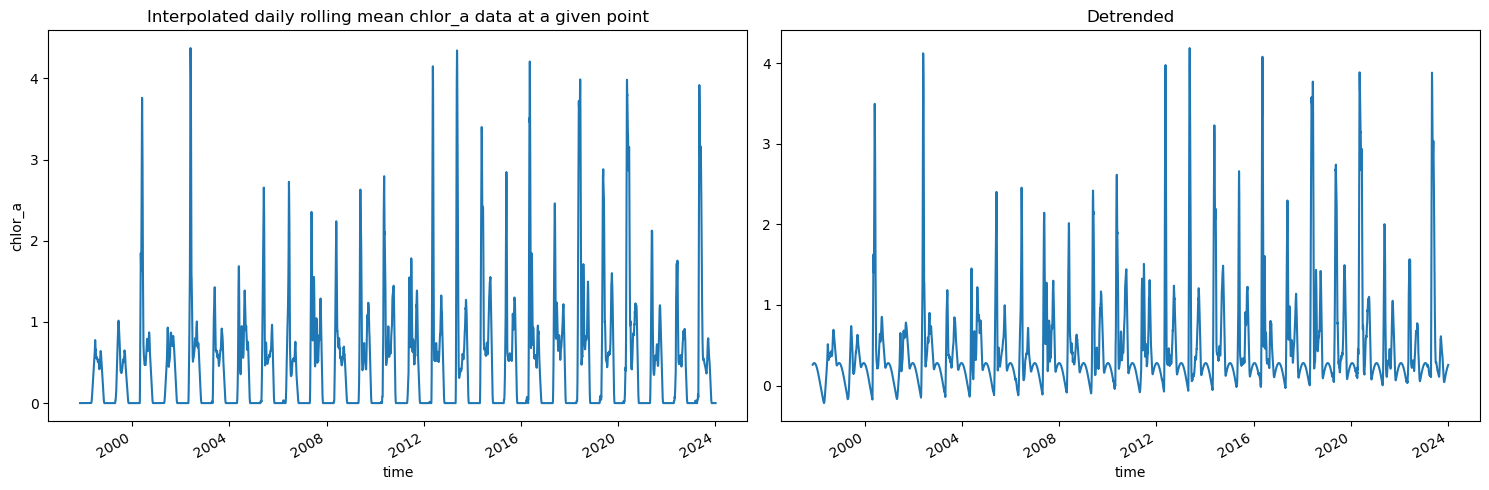

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the time series data on the first subplot
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Interpolated daily rolling mean chlor_a data at a given point')

# Plot the time series data on the first subplot
rolling_mean_detrended.plot(ax=axs[1])
axs[1].set_title('Detrended')


plt.tight_layout()
plt.show()

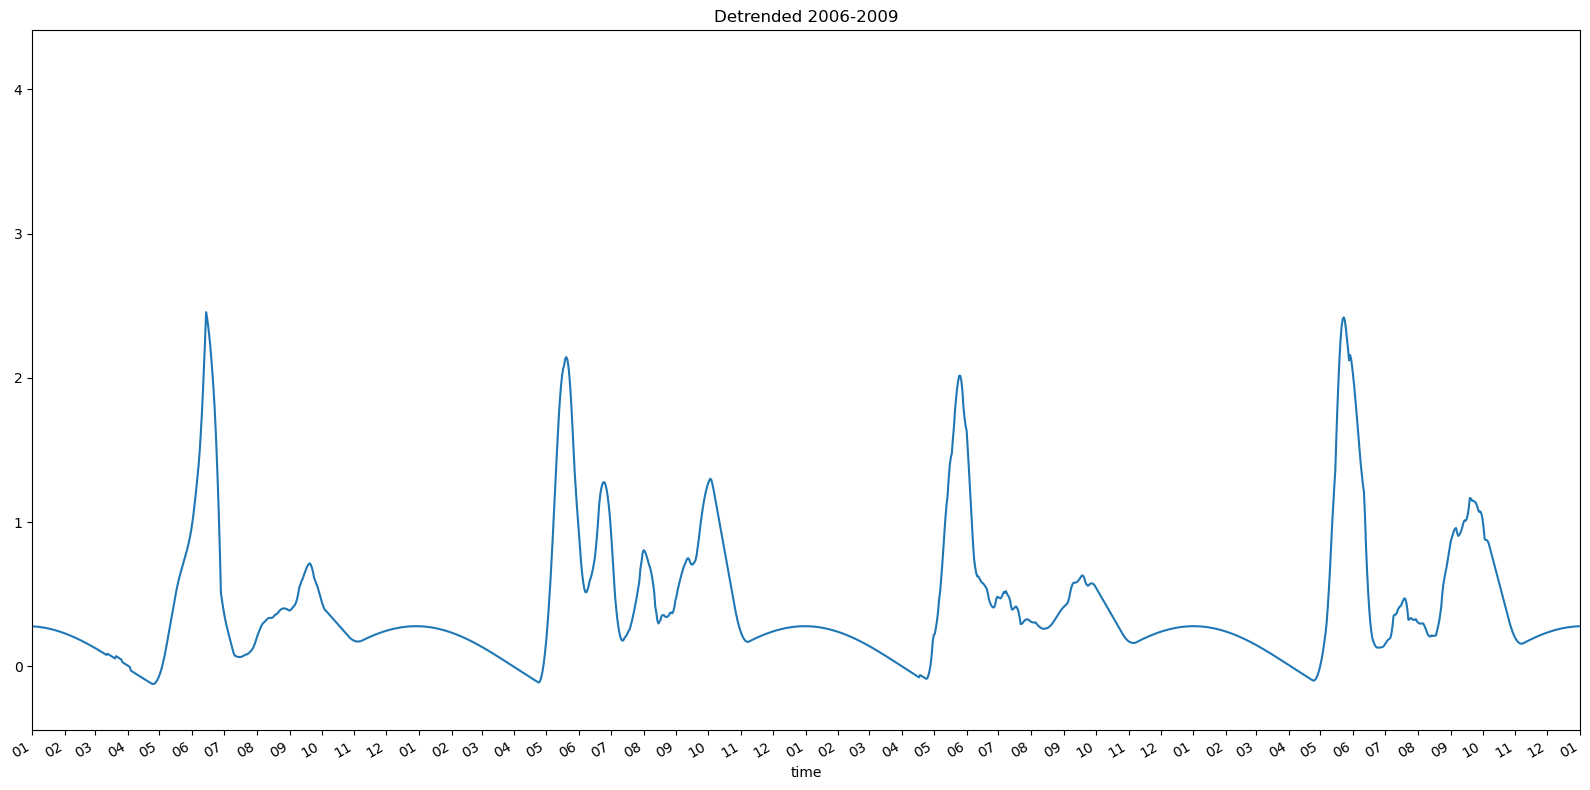

In [117]:
import matplotlib.dates as mdates

# plot point
fig, ax = plt.subplots(figsize=(16, 8))

rolling_mean_detrended.plot(ax=ax)
plt.title('Detrended 2006-2009')

# Set major ticks to every year.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# get only 2006
ax.set_xlim([datetime(2006, 1, 1), datetime(2010, 1, 1)])

plt.tight_layout()
plt.show()

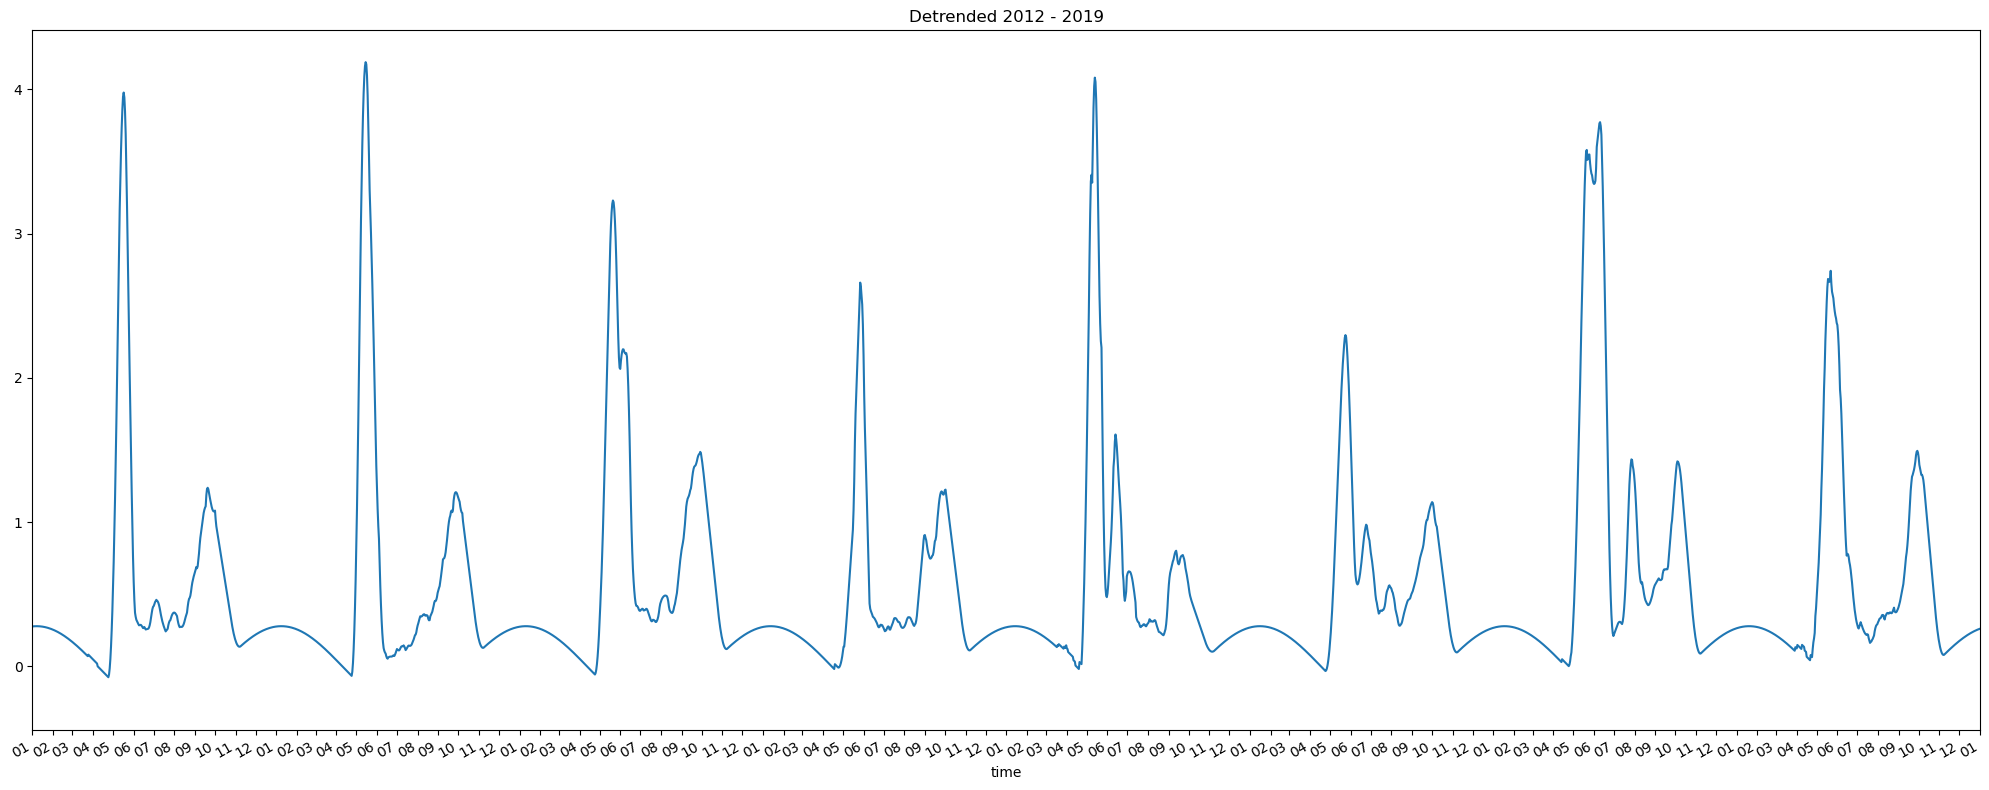

In [118]:
import matplotlib.dates as mdates

# plot point
fig, ax = plt.subplots(figsize=(20, 8))

rolling_mean_detrended.plot(ax=ax)
plt.title('Detrended 2012 - 2019')

# Set major ticks to every year.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# get only 2006
ax.set_xlim([datetime(2012, 1, 1), datetime(2020, 1, 1)])

plt.tight_layout()
plt.show()

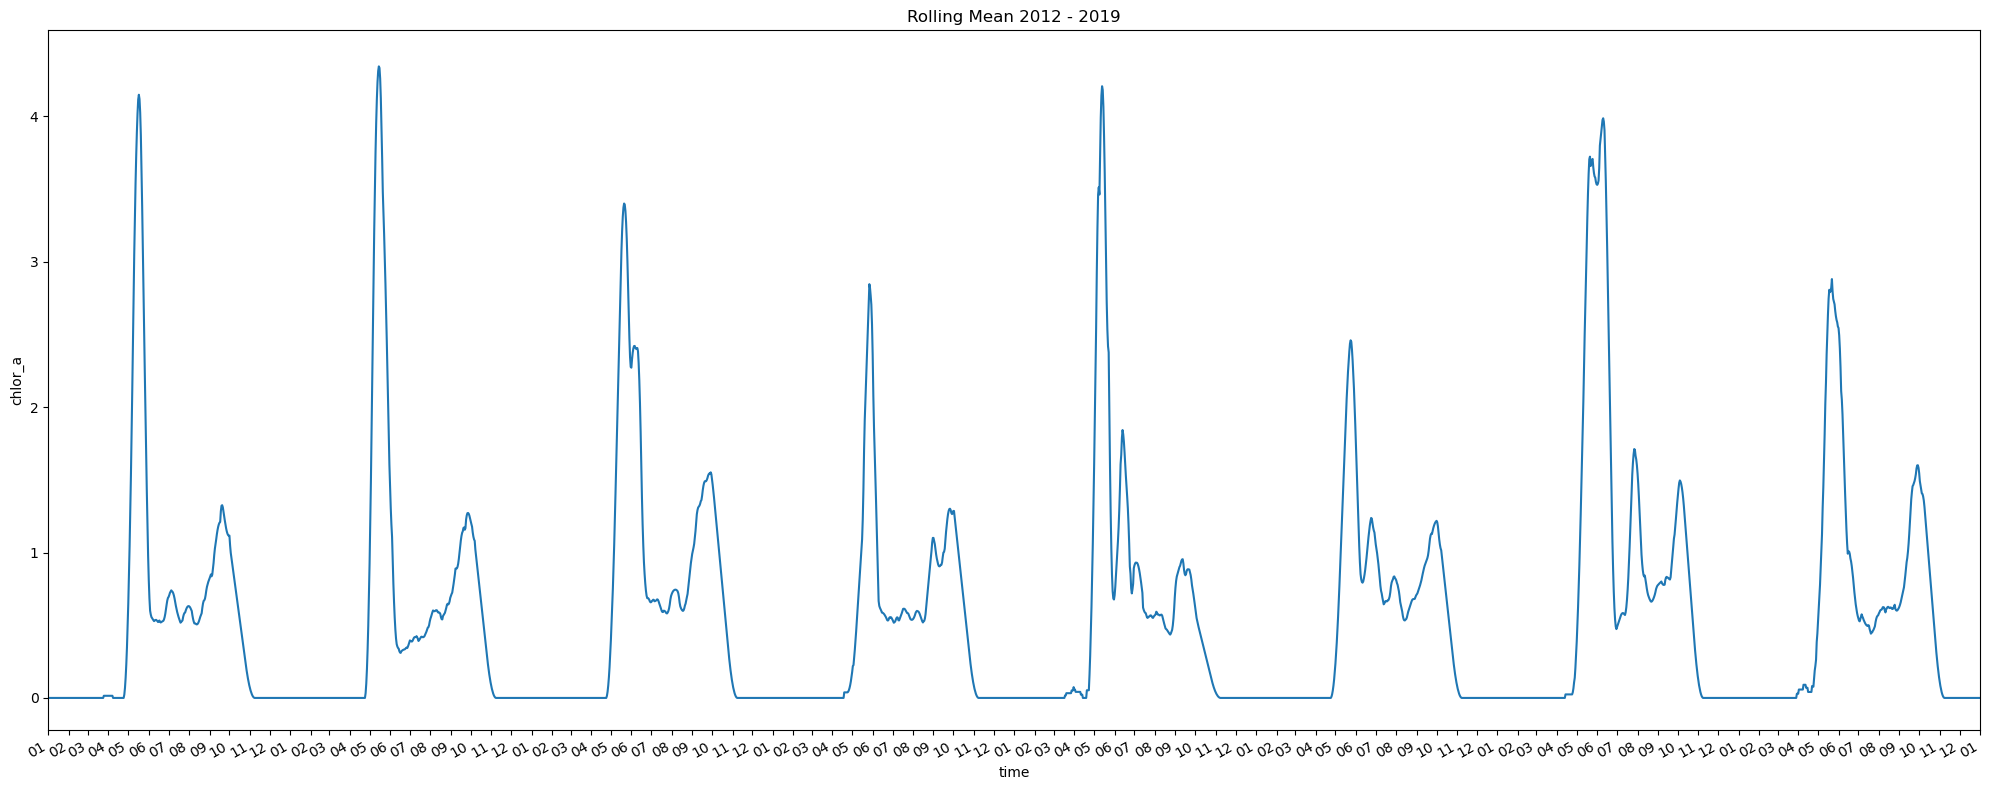

In [119]:
import matplotlib.dates as mdates

# plot point
fig, ax = plt.subplots(figsize=(20, 8))

rolling_mean.plot(ax=ax)
plt.title('Rolling Mean 2012 - 2019')

# Set major ticks to every year.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# get only 2006
ax.set_xlim([datetime(2012, 1, 1), datetime(2020, 1, 1)])

plt.tight_layout()
plt.show()

In [120]:
# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Use these indices to get the corresponding frequencies
dominant_freqs = freqs[sorted_indices]

print(1/dominant_freqs[0:10])

[ 367.03846154  122.34615385  120.79746835   72.84732824  183.51923077
   60.78343949   90.88571429  353.44444444  180.05660377 9543.        ]


#### remove top N frequencies

In [121]:
# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Use these indices to get the corresponding frequencies
dominant_freqs = freqs[sorted_indices]

print(1/dominant_freqs[0:10])

[ 367.03846154  122.34615385  120.79746835   72.84732824  183.51923077
   60.78343949   90.88571429  353.44444444  180.05660377 9543.        ]


In [122]:
N = 4  # Number of frequencies to include in Seasonality 
# Ns = [0,1,2,3]

# Get the indices that would sort the FFT amplitudes in descending order
sorted_indices = np.argsort(fft_abs[:len(fft_abs)//2])[::-1]

# Create an array of zeros with the same length as fft_vals
fourier_series = np.zeros_like(fft_vals)

# Set the values at the indices of the top N frequencies to their corresponding values in fft_vals
for i in range(N):
# for i in Ns:
    fourier_series[sorted_indices[i]] = fft_vals[sorted_indices[i]]

# Compute the inverse Fourier Transform to get the time series
Tseasonal = np.fft.ifft(fourier_series)
Tseasonal = Tseasonal.real

# Create an empty array with the same shape as pixel_data, filled with NaNs
Tseasonal_full = np.full_like(pixel_data, np.nan)

Tseasonal_full[valid_mask] = Tseasonal

# Now Tseasonal_full can be subtracted from rolling_mean
rolling_mean_detrended_N = rolling_mean - xr.DataArray(Tseasonal_full, dims=rolling_mean.dims, coords=rolling_mean.coords)


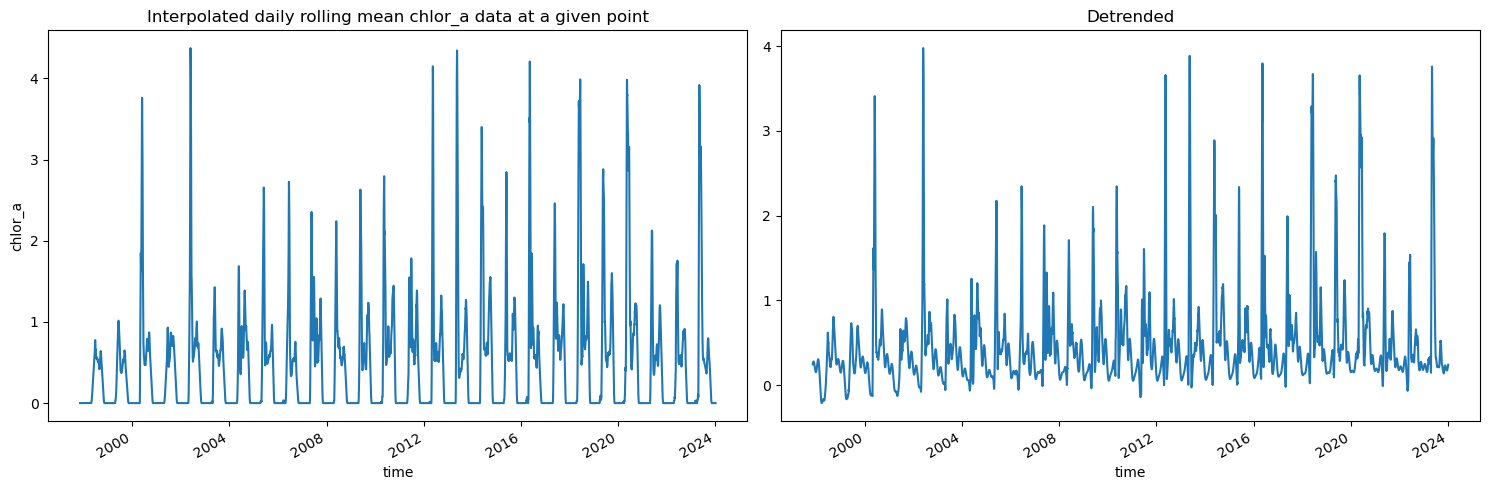

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the time series data on the first subplot
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Interpolated daily rolling mean chlor_a data at a given point')

# Plot the time series data on the first subplot
rolling_mean_detrended_N.plot(ax=axs[1])
axs[1].set_title('Detrended')


plt.tight_layout()
plt.show()

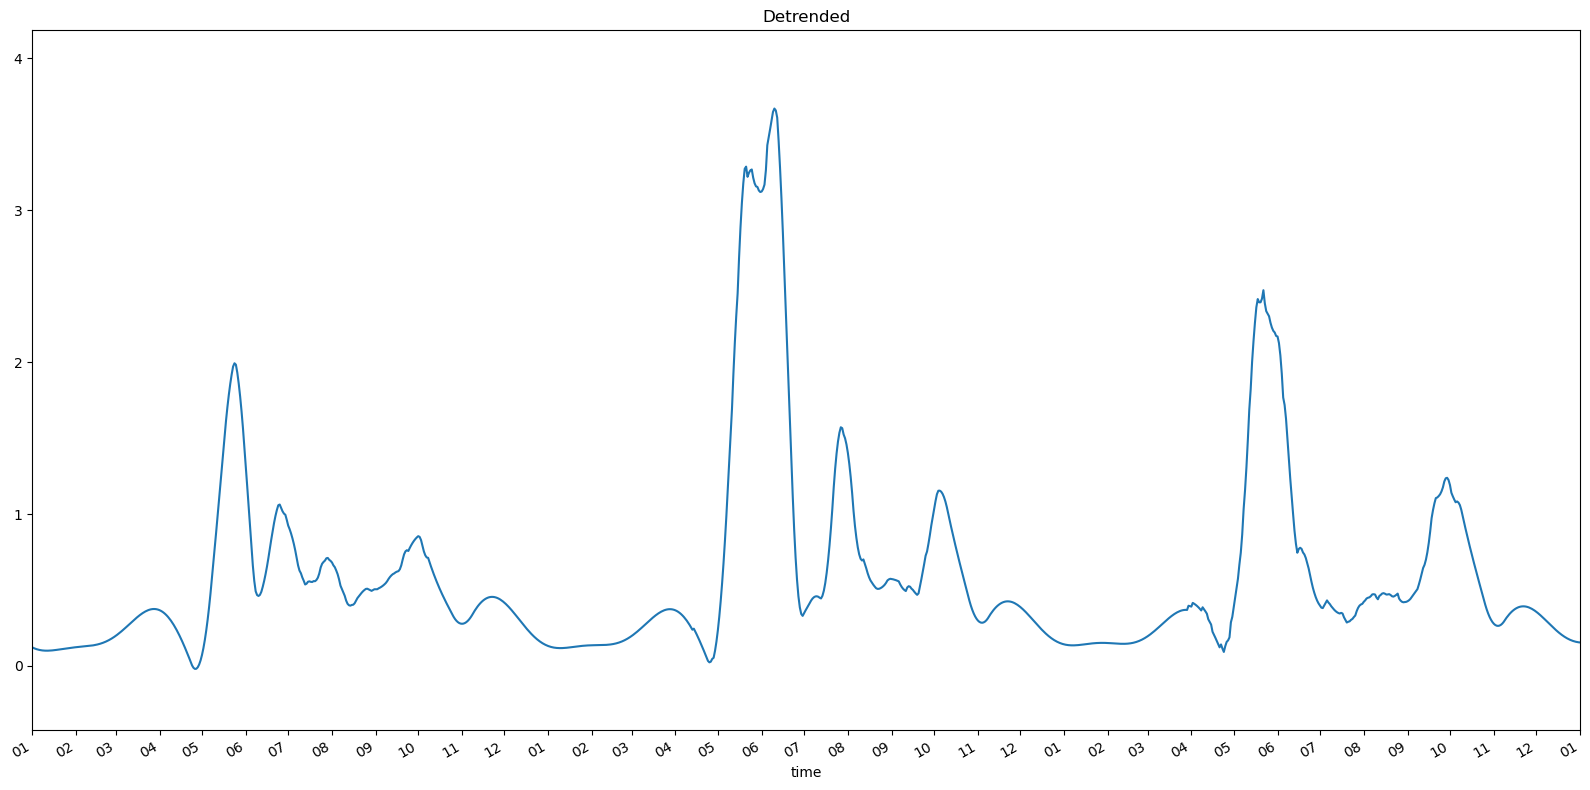

In [126]:
import matplotlib.dates as mdates

# plot point
fig, ax = plt.subplots(figsize=(16, 8))

rolling_mean_detrended_N.plot(ax=ax)
plt.title('Detrended')

# Set major ticks to every year.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# get only 2006
ax.set_xlim([datetime(2017, 1, 1), datetime(2020, 1, 1)])

plt.tight_layout()
plt.show()

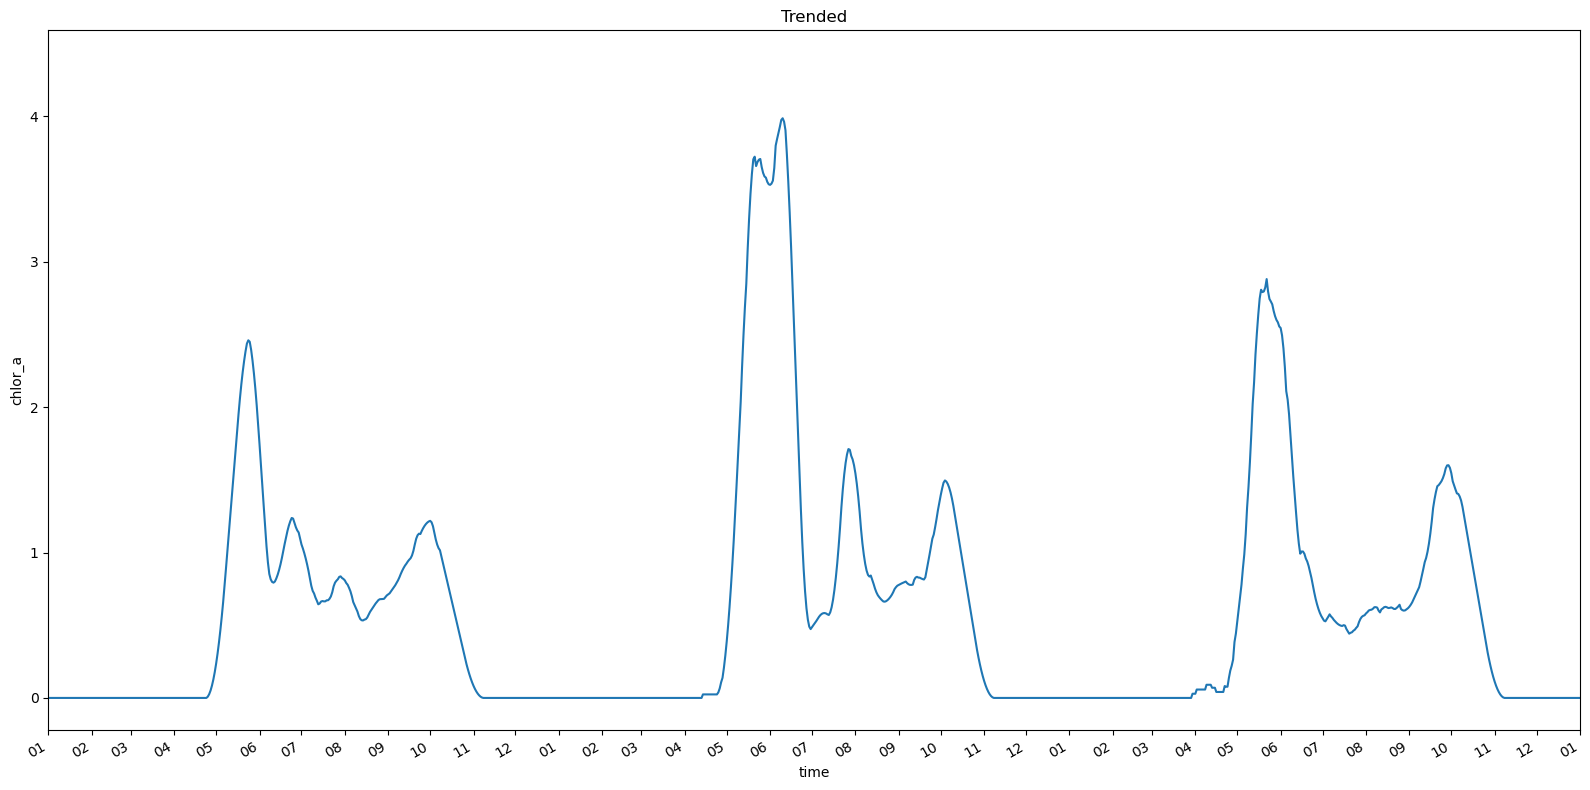

In [127]:
import matplotlib.dates as mdates

# plot point
fig, ax = plt.subplots(figsize=(16, 8))

rolling_mean.plot(ax=ax)
plt.title('Trended')

# Set major ticks to every year.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# get only 2006
ax.set_xlim([datetime(2017, 1, 1), datetime(2020, 1, 1)])

plt.tight_layout()
plt.show()

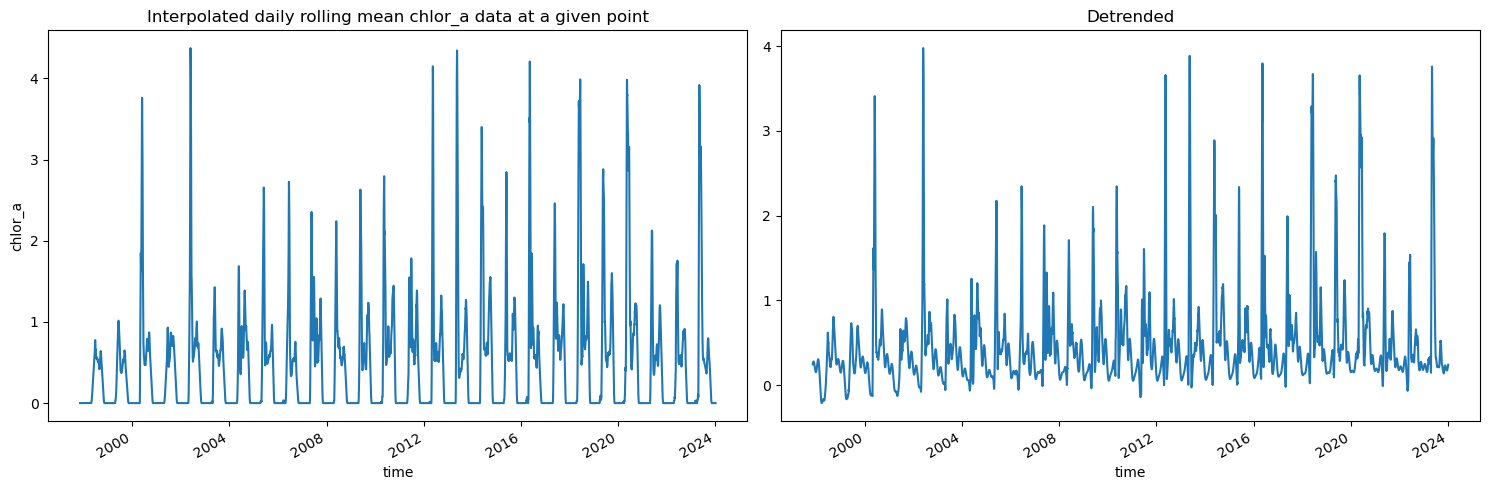

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the time series data on the first subplot
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Interpolated daily rolling mean chlor_a data at a given point')

# Plot the time series data on the first subplot
rolling_mean_detrended_N.plot(ax=axs[1])
axs[1].set_title('Detrended')


plt.tight_layout()
plt.show()